# Assignment 3: Predicting Used Car Prices Using Multiple Regression Models

Name: Sudip Shrestha \
Student ID: C0934400

**Dataset** \
https://www.kaggle.com/datasets/sukhmandeepsinghbrar/car-price-prediction-dataset

**Imports**

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_predict, KFold
import joblib

**Data Preprocessing**

Loading the dataset

In [2]:
#Loading the dataset
df = pd.read_csv('used_car_data.csv')

#Displaying the first few rows
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78,5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.2,5.0


Data Cleaning

In [3]:
#Checking for missing values
print("Missing values:\n", df.isnull().sum())

#Dropping rows with missing values (or you can fill them if preferred)
df = df.dropna()

#Removing duplicate rows
df = df.drop_duplicates()

#Confirming cleaning
print("Shape after cleaning:", df.shape)


Missing values:
 name                    0
year                    0
selling_price           0
km_driven               0
fuel                    0
seller_type             0
transmission            0
owner                   0
mileage(km/ltr/kg)    221
engine                221
max_power             215
seats                 221
dtype: int64
Shape after cleaning: (6718, 12)


Creating New Feature

In [4]:
#Defining current year
current_year = datetime.now().year

#Creating new column
df['car_age'] = current_year - df['year']

#Previewing
df[['year', 'car_age']].head()

,year,car_age
0,2014,11
1,2014,11
2,2006,19
3,2010,15
4,2007,18


Converting Price column which is in INR to CAD

In [5]:
#Defining conversion rate
conversion_rate = 0.0165  

#Creating a new column for price in CAD
df['price'] = df['selling_price'] * conversion_rate

#Dropping original INR price as we now have the price in CAD
df = df.drop('selling_price', axis=1)

#Previewing only the new CAD column
df[['price']].head()

,price
0,7425.0
1,6105.0
2,2607.0
3,3712.5
4,2145.0


Dropping Irrelevant Features

In [6]:
#Dropping the 'name' column as it is not needed for analysis
df = df.drop('name', axis=1)

#Checking remaining columns
df.columns

Index(['year', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner',
       'mileage(km/ltr/kg)', 'engine', 'max_power', 'seats', 'car_age',
       'price'],
      dtype='object')

Convert categorical variables using Label Encoding.

In [7]:
#Checking for categorical variables
cat_cols = df.select_dtypes(include='object').columns
print("Categorical columns:", cat_cols)

#Applying Label Encoding
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

#Previewing the cleaned and transformed DataFrame
df.head()

Categorical columns: Index(['fuel', 'seller_type', 'transmission', 'owner', 'max_power'], dtype='object')


,year,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats,car_age,price
0,2014,145500,1,1,1,0,23.40,1248.0,243,5.0,11,7425.0
1,2014,120000,1,1,1,2,21.14,1498.0,14,5.0,11,6105.0
2,2006,140000,3,1,1,4,17.70,1497.0,252,5.0,19,2607.0
3,2010,127000,1,1,1,0,23.00,1396.0,294,5.0,15,3712.5
4,2007,120000,3,1,1,0,16.10,1298.0,286,5.0,18,2145.0


Scaling Features

In [8]:
#Selecting numeric features
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

#Initializing scaler
scaler = StandardScaler()

#Scaling and create new DataFrame
df_scaled = pd.DataFrame(scaler.fit_transform(df[numeric_cols]), columns=numeric_cols)

#Previewing scaled data
df_scaled.head()

,year,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats,car_age,price
0,0.100219,1.228336,-0.880699,0.310061,0.305945,-0.707323,0.971805,-0.370633,0.526778,-0.44165,-0.100219,-0.145787
1,0.100219,0.793890,-0.880699,0.310061,0.305945,0.898013,0.413621,0.135997,-2.016311,-0.44165,-0.100219,-0.298604
2,-1.950875,1.134632,1.115097,0.310061,0.305945,2.503349,-0.436003,0.133971,0.626724,-0.44165,1.950875,-0.703570
3,-0.925328,0.913149,-0.880699,0.310061,0.305945,-0.707323,0.873011,-0.070708,1.093142,-0.44165,0.925328,-0.575586
4,-1.694488,0.793890,1.115097,0.310061,0.305945,-0.707323,-0.831177,-0.269307,1.004301,-0.44165,1.694488,-0.757056


**Exploratory Data Analysis**

Price Distribution

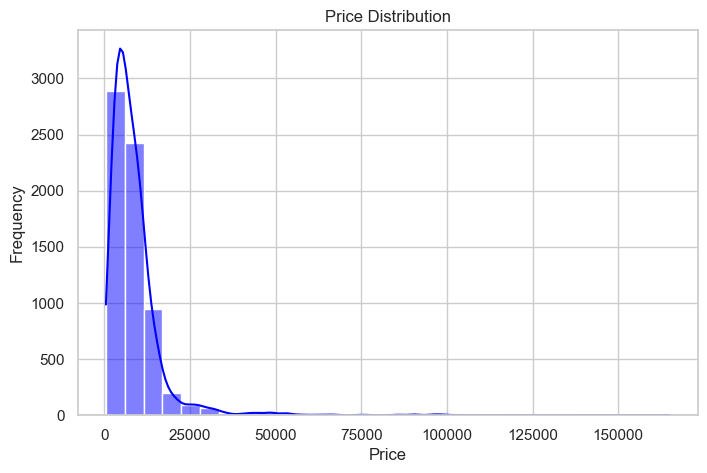

In [9]:
#Setting plot style
sns.set(style="whitegrid")

#Plotting price distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['price'], kde=True, bins=30, color='blue')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()


Correlation Heatmap

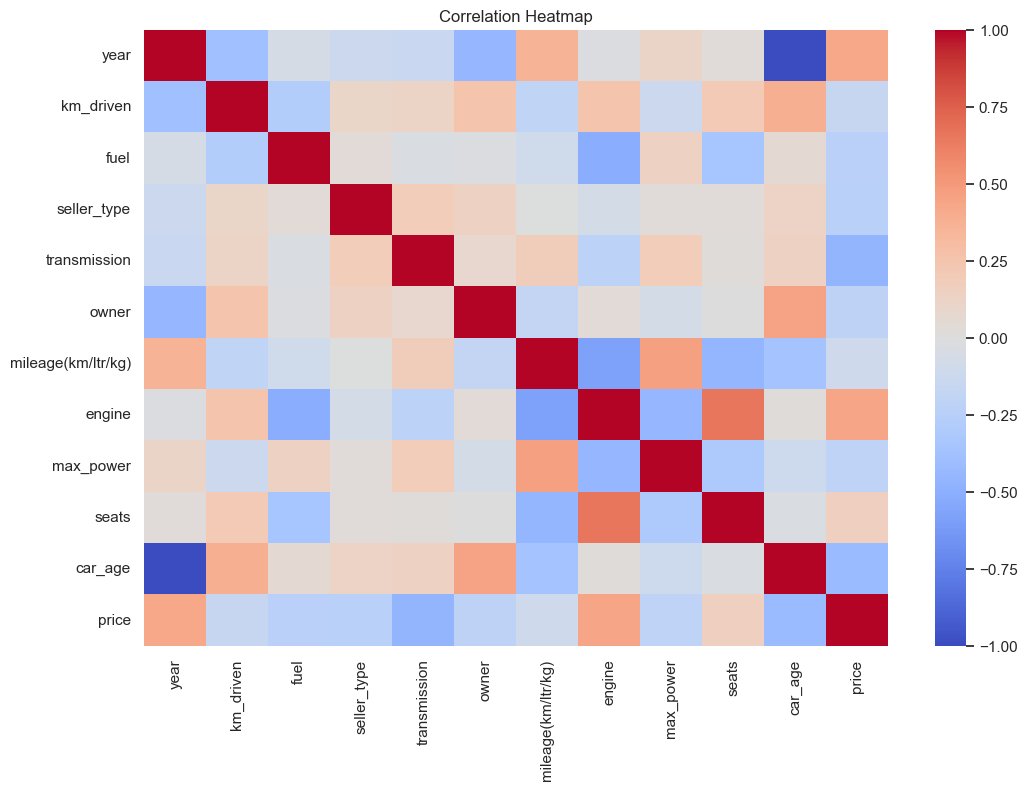

In [10]:
#Computing correlation
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Box plots for categorical features vs price

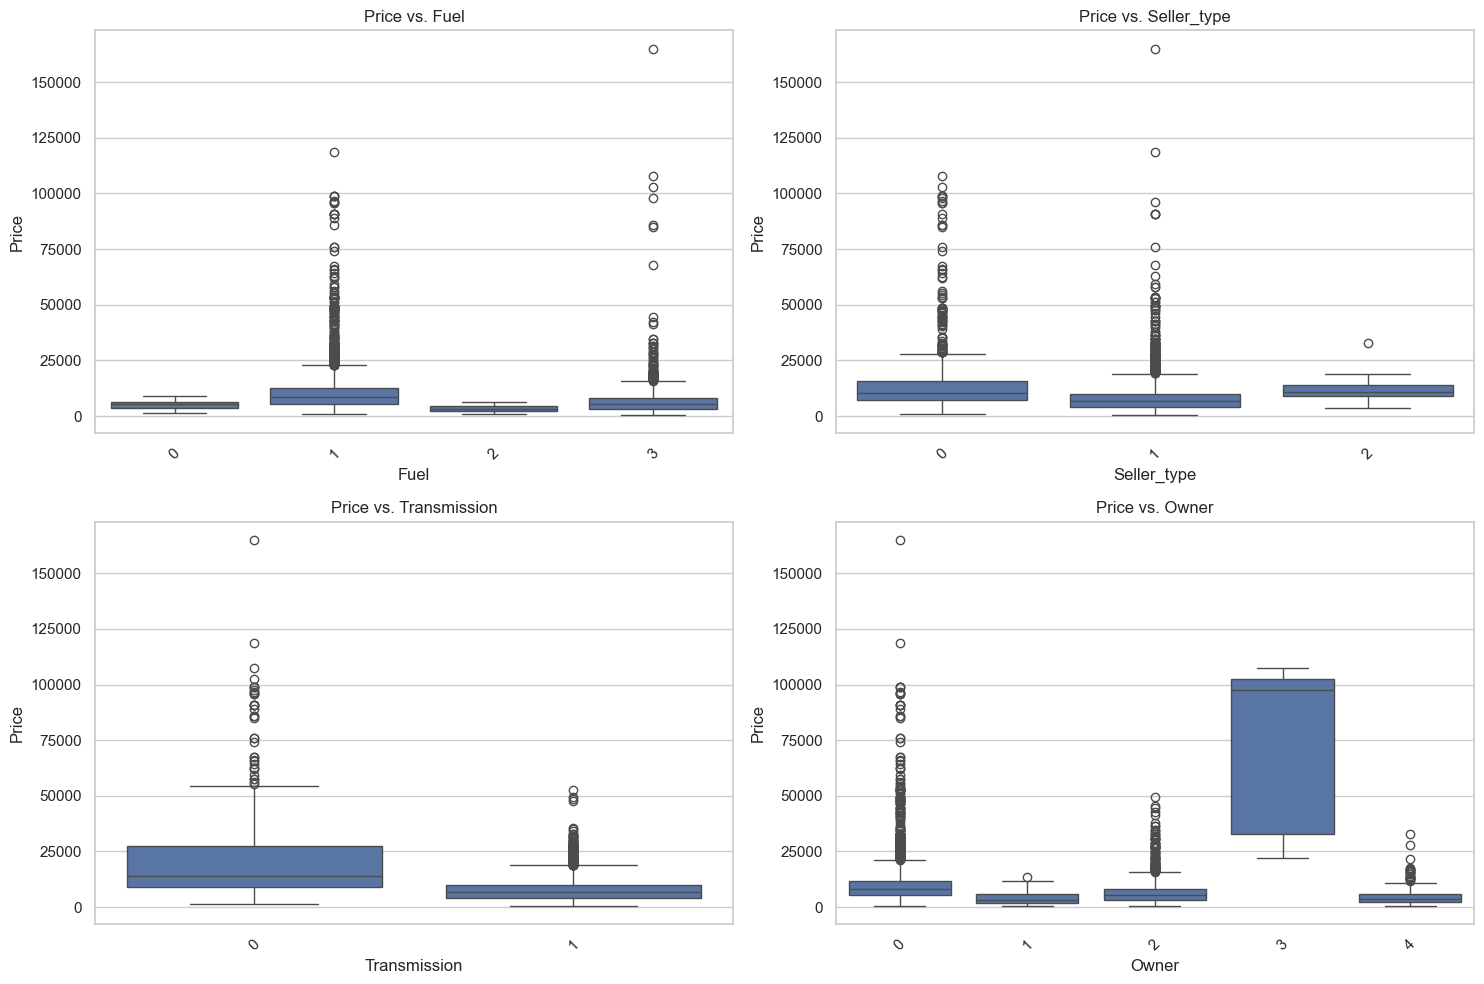

In [11]:
#Defining the categorical columns
cat_cols = ['fuel', 'seller_type', 'transmission', 'owner']

#Setting up subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

#Plotting each boxplot
for i, col in enumerate(cat_cols):
    sns.boxplot(x=df[col], y=df['price'], ax=axes[i])
    axes[i].set_title(f'Price vs. {col.capitalize()}')
    axes[i].set_xlabel(col.capitalize())
    axes[i].set_ylabel('Price')
    axes[i].tick_params(axis='x', rotation=45)

#Adjusting layout
plt.tight_layout()
plt.show()


Histogram for numerical features

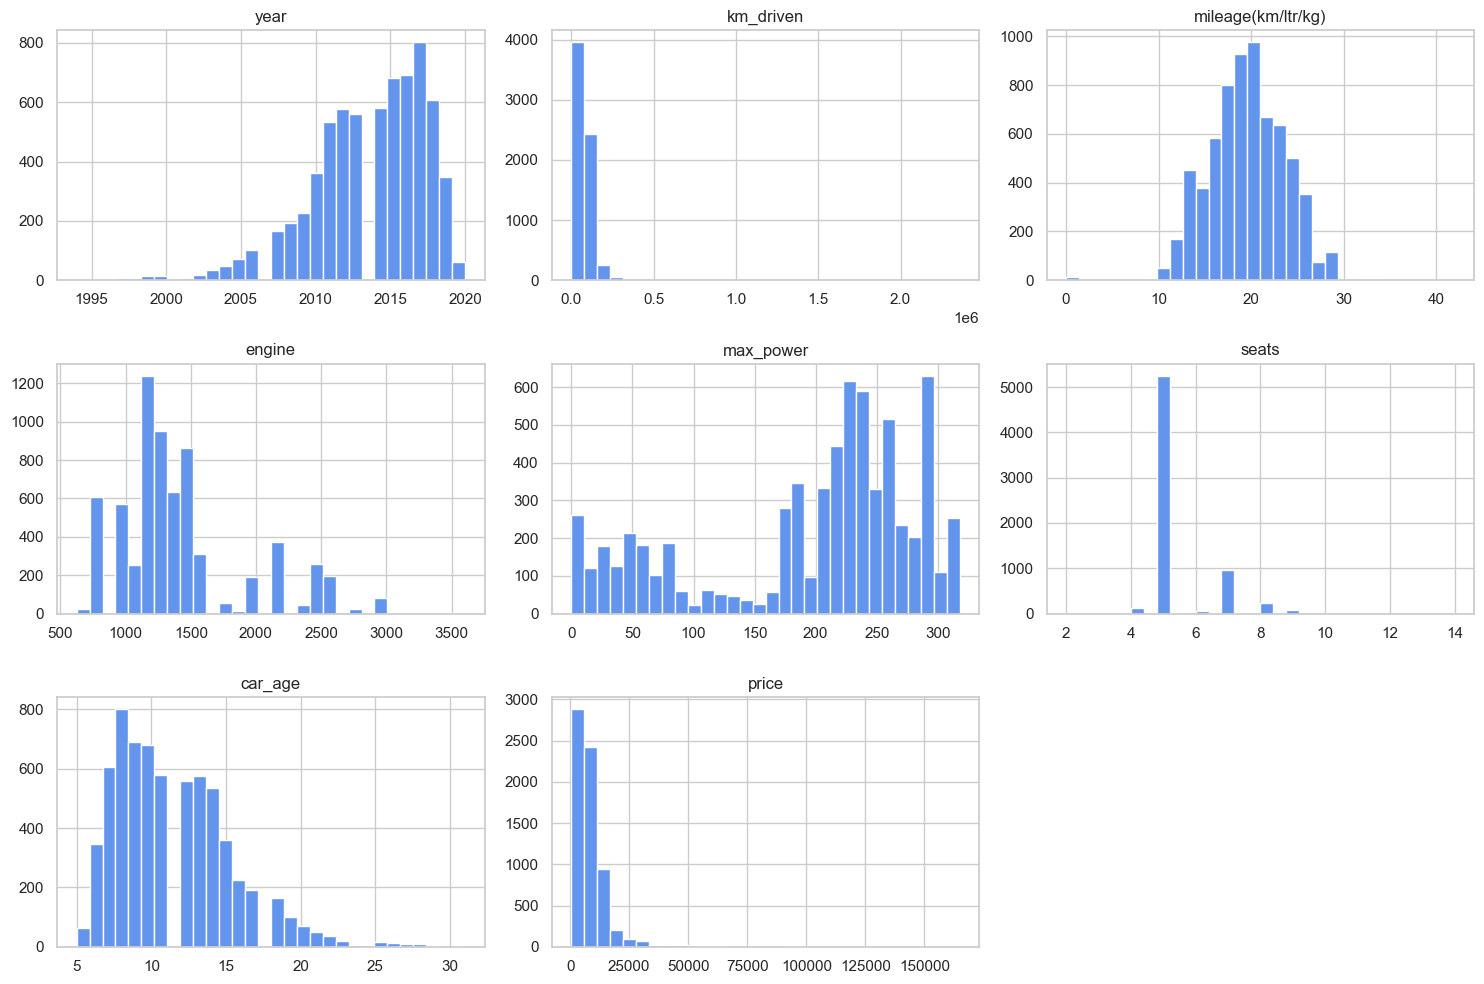

In [12]:
#Numerical features
num_cols = ['year', 'km_driven', 'mileage(km/ltr/kg)', 'engine', 'max_power', 'seats', 'car_age', 'price']

#Histograms
df[num_cols].hist(bins=30, figsize=(15, 10), color='cornflowerblue')
plt.tight_layout()
plt.show()

Scatter Plot for numerical features

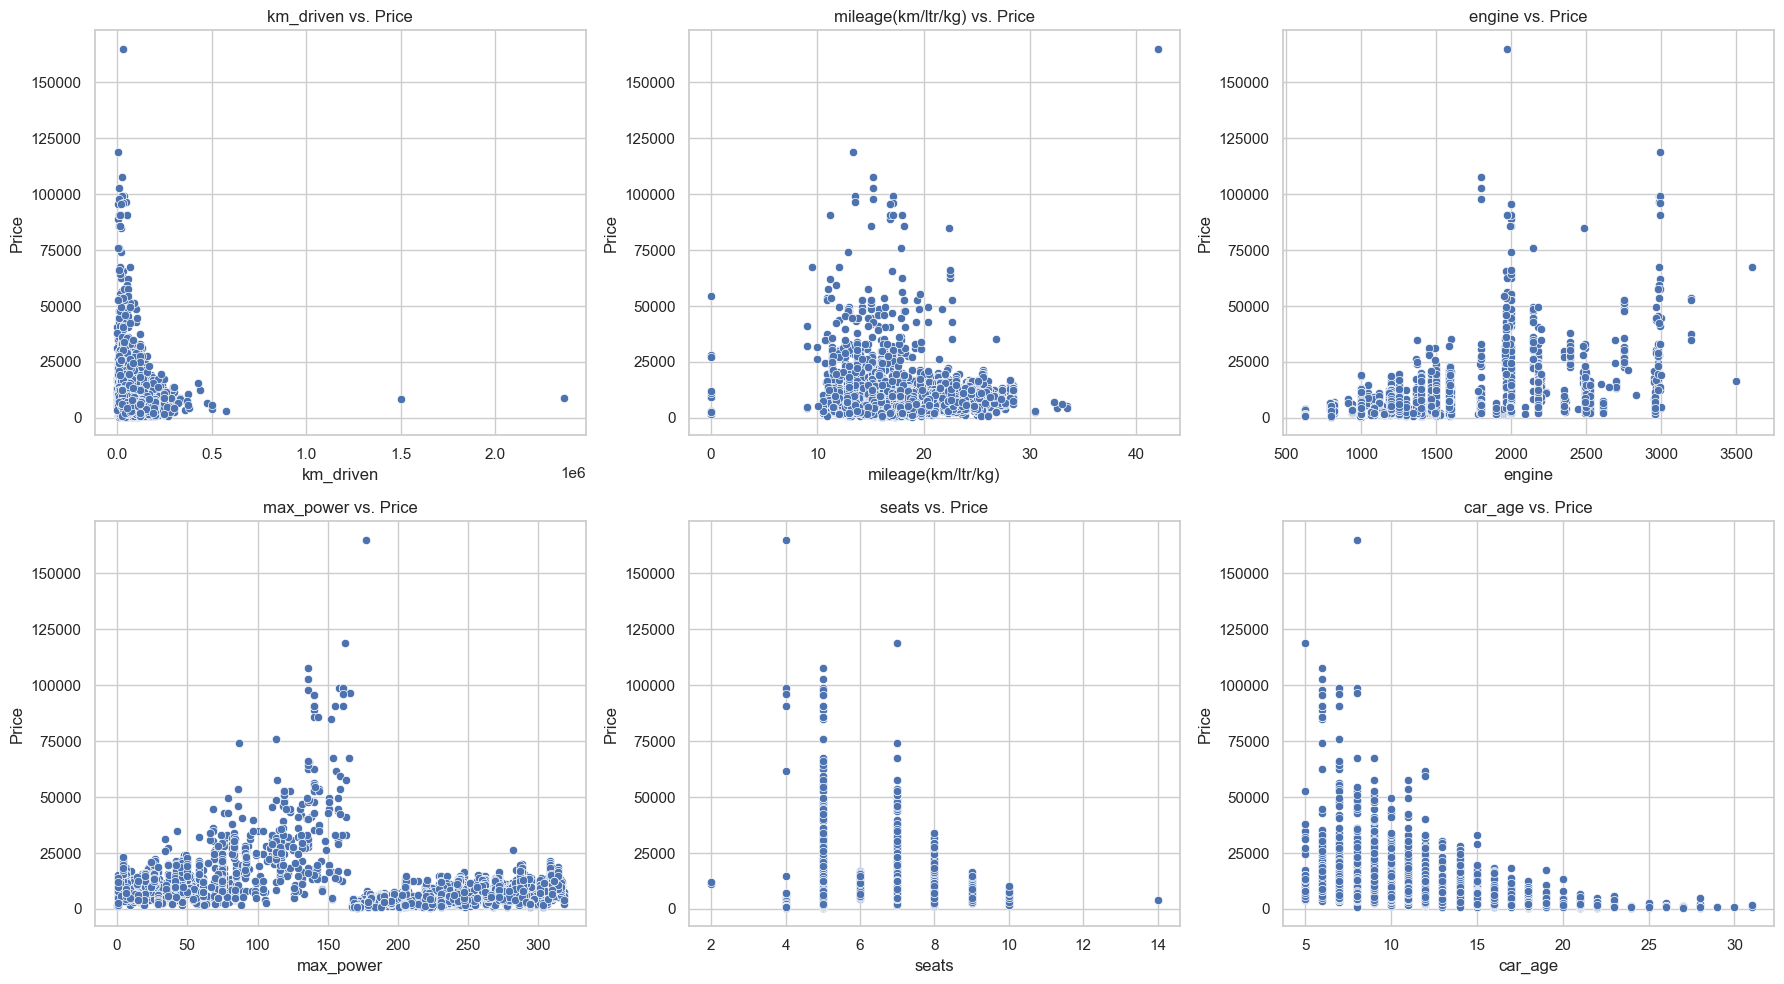

In [13]:
#Features to plot
features_to_plot = ['km_driven', 'mileage(km/ltr/kg)', 'engine', 'max_power', 'seats', 'car_age']

#Setting up subplots: 2 rows, 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

#Generating scatter plots
for i, feature in enumerate(features_to_plot):
    sns.scatterplot(x=df[feature], y=df['price'], ax=axes[i])
    axes[i].set_title(f'{feature} vs. Price')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Price')

#Adjusting layout
plt.tight_layout()
plt.show()


Average price per owner type

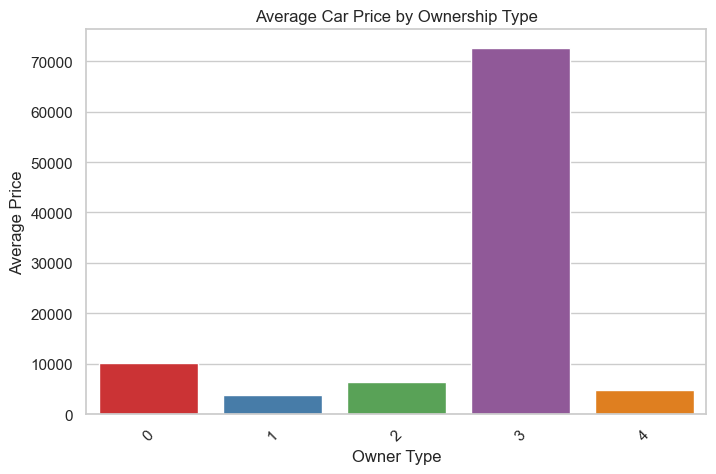

In [14]:
#Average price per owner type
plt.figure(figsize=(8, 5))
sns.barplot(x='owner', y='price', data=df, estimator='mean', errorbar=None, hue='owner', legend=False, palette='Set1')
plt.title('Average Car Price by Ownership Type')
plt.xlabel('Owner Type')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()


**Model Building**

Data split into train and test

In [15]:
#Seperating features and target variable
#Taking all columns except 'price' as features from scaled DataFrame
X = df_scaled.drop(columns=['price'])
#Taking 'price' as the target variable
y = df['price']                  

#Splitting data into train and test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#Checking the shape
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5374, 11)
X_test shape: (1344, 11)
y_train shape: (5374,)
y_test shape: (1344,)


Linear Regression Model

In [16]:
#Initializing the linear regression model
lr_model = LinearRegression()

#Training the model on training data
lr_model.fit(X_train, y_train)

LinearRegression()

Ridge Regression Model

In [17]:
#Initializing Ridge Regression model
ridge_model = Ridge()

#Training the Ridge model on training data
ridge_model.fit(X_train, y_train)

Ridge()

Random Forest Regressor Model

In [18]:
#Initializing Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

#Training the model on training data
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

XGBoost Regressor Model

In [19]:
#Initializing XGBoost Regressor
xgb_model = XGBRegressor(random_state=42)

#Training the model on training data
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

CatBoost Regressior

In [20]:
#Initializing CatBoost Regressor
catboost_model = CatBoostRegressor(random_state=42, verbose=0)

#Training the CatBoost model on training data
catboost_model.fit(X_train, y_train)

**Model Evaluation**

In [21]:
#Function to evaluate model using R2 Score, MAE, and RMSE
def evaluate_model(name, model, X_test, y_test):
    #Generating predictions using the model
    y_pred = model.predict(X_test)
    
    #Calculating R² score (explained variance)
    r2 = r2_score(y_test, y_pred)
    
    #Calculating Mean Absolute Error
    mae = mean_absolute_error(y_test, y_pred)
    
    #Calculating Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    #Printing formatted evaluation results
    print(f"{name}:\n R2 Score: {r2:.4f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}\n")

#Evaluating each trained model on the test set
evaluate_model("Linear Regression", lr_model, X_test, y_test)
evaluate_model("Ridge Regression", ridge_model, X_test, y_test)
evaluate_model("Random Forest", rf_model, X_test, y_test)
evaluate_model("XGBoost", xgb_model, X_test, y_test)
evaluate_model("CatBoost", catboost_model, X_test, y_test)

Linear Regression:
 R2 Score: 0.5674, MAE: 3020.24, RMSE: 4555.92

Ridge Regression:
 R2 Score: 0.5675, MAE: 3018.82, RMSE: 4555.07

Random Forest:
 R2 Score: 0.8847, MAE: 1270.29, RMSE: 2351.86

XGBoost:
 R2 Score: 0.8810, MAE: 1252.85, RMSE: 2389.66

CatBoost:
 R2 Score: 0.8866, MAE: 1229.35, RMSE: 2332.79



In [22]:
#Defining 5-Fold cross-validation strategy with shuffle for randomness
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#Function to evaluate a model using cross-validation
def cross_val_evaluate(name, model):
    #Generating cross-validated predictions for the entire dataset
    y_pred = cross_val_predict(model, X, y, cv=kf)
    
    #Calculating R² score
    r2 = r2_score(y, y_pred)
    
    #Calculating Mean Absolute Error
    mae = mean_absolute_error(y, y_pred)
    
    #Calculating Root Mean Squared Erro (penalizes larger errors)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    #Printing results for the model
    print(f"{name} (5-Fold CV):\n R2 Score: {r2:.4f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}\n")

#Performing cross-validation evaluation for each trained model
cross_val_evaluate("Linear Regression", lr_model)
cross_val_evaluate("Ridge Regression", ridge_model)
cross_val_evaluate("Random Forest", rf_model)
cross_val_evaluate("XGBoost", xgb_model)
cross_val_evaluate("CatBoost", catboost_model)

Linear Regression (5-Fold CV):
 R2 Score: 0.5126, MAE: 3176.63, RMSE: 6030.51

Ridge Regression (5-Fold CV):
 R2 Score: 0.5126, MAE: 3175.40, RMSE: 6030.50

Random Forest (5-Fold CV):
 R2 Score: 0.8958, MAE: 1333.44, RMSE: 2788.01

XGBoost (5-Fold CV):
 R2 Score: 0.8809, MAE: 1316.45, RMSE: 2980.84

CatBoost (5-Fold CV):
 R2 Score: 0.8942, MAE: 1278.35, RMSE: 2809.17



**Model Selection**

| Model(With 5-fold cv)| R² Score | MAE       | RMSE     |
|----------------------|----------|-----------|----------|
| Linear Regression    | 0.5126   | 3176.63   | 6030.51  |
| Ridge Regression     | 0.5126   | 3175.40   | 6030.50  |
| Random Forest        | 0.8958   | 1333.44   | 2788.01  |
| XGBoost              | 0.8809   | 1316.45   | 2980.84  |
| CatBoost             | 0.8942   | 1278.35   | 2809.17  |


Since Random Forest Regressor model has lowest RMSE(2788.01) and higherst R²(0.8958) which indicates best performance among the models, We will be using Random Forest Regressor model.

**Model Saving**

In [23]:
#Saving model
joblib.dump(rf_model, 'random_forest_model.pkl')

['random_forest_model.pkl']

**Loading Saved Model**

In [24]:
#Loading model
rf_model = joblib.load('random_forest_model.pkl')
print("Model loaded successfully.")

Model loaded successfully.


**Conclusion**

With this saved model we can predict the used car prices based on the other parameters.